In [1]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [2]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10 
M = 10
PHI = []
IsSynthetic = False

In [3]:
# This function reads the target labels for the data to give us the target values 't' in the linear regression.
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

# This function reads the input data from the csv file and stores it in a matrix to create the training data.
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        # These columns are not inculded in the input data because they contain all 0's and hence their variance = 0, which in turn would make the covariance matrix un-invertible. 
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)    
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

# This function selects the 80% of target values for training data which is also 80% of input data.
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

# This functin selects only 80% of the input data for training and saves the rest for cross-validation and testing.
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

# This functin selects only 10% of the input data remaining after training and saves the rest for testing.
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# This function generates the covariance matrix (matrix containing variances of data points from cluster centroids) that will be used while calculating the Gaussian Radial Basis functions.
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

#This is a helper function for GetPhiMatrix function, which computes the composite scalar which is used inside the exponent of e in gaussian kernel.
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

#this is another helper function that generates the final exponential term of gaussian kernel to generate the phi_matrix.
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# This function generates the radial basis functions, PHI over feature Matrix X. This function gets called for every centroid, which is a vector of mean value of respective feature values of data points in that particular cluster.
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#This function trains and returns the weights of our linear regression model using the Moore_Penrose pseudo inverse.
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

#This function computes the Root Mean Square Error, which our cost function, and also the accuracy, for the predicted value vs actual target value.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [4]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 'U' mode is deprecated
  


## Prepare Training Data

In [5]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [6]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [7]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [8]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) # Clusteer the data to create centroids (mean values) which will be used to compute gaussian kernals 
Mu = kmeans.cluster_centers_ #matrix containing the mean values of features for every data point in each cluster

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic) # compute the covariance Matrix
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent) # Compute the Gaussian radial basis for training data.
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) #train the weights for linear regression model using closed form solution.
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [9]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))


print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = %d \nLambda = 0.9"%M)
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.5494694067137861
E_rms Validation = 0.5384281741389029
E_rms Testing    = 0.6279788453856765


In [10]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 41)
(41, 41)
(55699, 10)
(10,)
(6962, 10)
(6961, 10)


### Tuning the number of clusters.


(55699, 10)
(10,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.5494694067137861
E_rms Validation = 0.5384281741389029
E_rms Testing    = 0.6279788453856765
(55699, 15)
(15,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 15 
Lambda = 0.9
E_rms Training   = 0.5469930517882835
E_rms Validation = 0.537463214291947
E_rms Testing    = 0.6273341085294319
(55699, 20)
(20,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 20 
Lambda = 0.9
E_rms Training   = 0.5461233210909291
E_rms Validation = 0.5383600398443413
E_rms Testing    = 0.6261902077808426
(55699, 25)
(25,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 25 
Lambda = 0.9
E_rms Training   = 0.5447185561414625
E_rms Validation = 0.5377070882431654
E_r

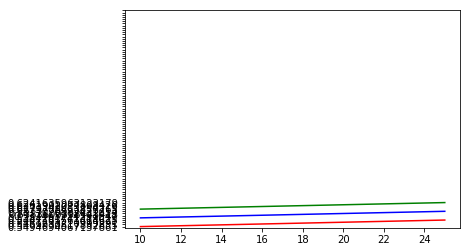

In [11]:
ErmsArr = []
AccuracyArr = []
number_of_clusters = [10,15,20,25]
Train_ERMS_list=[]
Val_ERMS_list=[]
Test_ERMS_list=[]
for m in number_of_clusters:
    kmeans = KMeans(n_clusters=m, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_

    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    
    Train_ERMS_list.append(TrainingAccuracy.split(',')[1])
    Val_ERMS_list.append(ValidationAccuracy.split(',')[1])
    Test_ERMS_list.append(TestAccuracy.split(',')[1])
    
    print(TRAINING_PHI.shape)
    print(W.shape)

    print ("-------Closed Form with Radial Basis Function-------")
    print ('----------------------------------------------------')
    print ("M = %d \nLambda = 0.9"%m)
    print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
    print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
    print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
    
    
    
plt.plot(number_of_clusters, Train_ERMS_list, 'r') 
plt.plot(number_of_clusters, Val_ERMS_list, 'b') 
plt.plot(number_of_clusters, Test_ERMS_list, 'g') 
plt.yticks(np.arange(0,100,1))
plt.show()

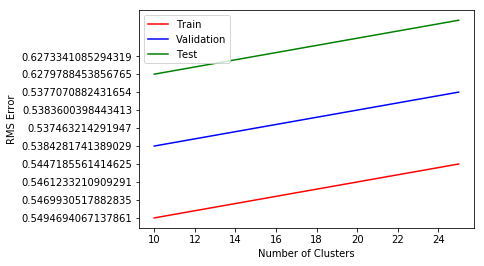

In [12]:
plt.plot(number_of_clusters, Train_ERMS_list, 'r',label='Train') 
plt.plot(number_of_clusters, Val_ERMS_list, 'b',label='Validation') 
plt.plot(number_of_clusters, Test_ERMS_list, 'g',label='Test') 
plt.yticks(np.arange(0,10,1))
plt.xlabel('Number of Clusters')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

### Tuning Lambda (Regularization Parameter)

In [13]:
ErmsArr = []
AccuracyArr = []
Train_accuracy_list=[]
Val_accuracy_list=[]
Test_accuracy_list=[]
C_Lambda_list=[0.03,0.06,0.12,0.24,0.48,0.96,1]
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
for C_Lambda in C_Lambda_list:
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

    Train_accuracy_list.append(TrainingAccuracy.split(',')[1])
    Val_accuracy_list.append(ValidationAccuracy.split(',')[1])
    Test_accuracy_list.append(TestAccuracy.split(',')[1])

    print(TRAINING_PHI.shape)
    print(W.shape)

    print ("-------Closed Form with Radial Basis Function-------")
    print ('----------------------------------------------------')
    print ("M = 10 \nLambda = %f"%C_Lambda)
    print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
    print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
    print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
    


    
    


(55699, 10)
(10,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.030000
E_rms Training   = 0.5494694067137861
E_rms Validation = 0.5384281741389029
E_rms Testing    = 0.6279788453856765
(55699, 10)
(10,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.060000
E_rms Training   = 0.5494893064251556
E_rms Validation = 0.5384610782694436
E_rms Testing    = 0.628055781001862
(55699, 10)
(10,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.120000
E_rms Training   = 0.5495253078549347
E_rms Validation = 0.5385425826803175
E_rms Testing    = 0.6281352464699802
(55699, 10)
(10,)
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.240000
E_rms Training   = 0.5495888208027151
E_rms Validation = 0.

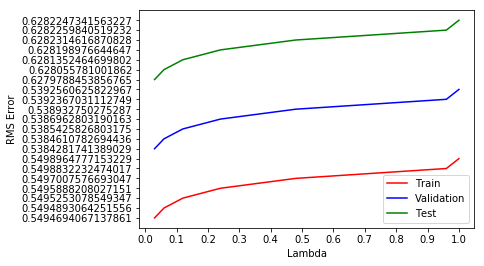

In [14]:
plt.plot(C_Lambda_list, Train_accuracy_list, 'r',label='Train') 
plt.plot(C_Lambda_list, Val_accuracy_list, 'b',label='Validation') 
plt.plot(C_Lambda_list, Test_accuracy_list, 'g',label='Test') 
plt.xticks(np.arange(0,1.1,0.1))
plt.xlabel('Lambda')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

## Finding Erms on training, validation and test set For M=10, C_Lambda=0.03

In [15]:
ErmsArr = []
AccuracyArr = []
M=10
C_Lambda=0.01
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [16]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [17]:
print ('UBITname      = agundroo')
print ('Person Number = 50289721')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = %f"%C_Lambda)
print ("Accuracy Training   = " + str(float(TrainingAccuracy.split(',')[0])))
print ("Accuracy Validation = " + str(float(ValidationAccuracy.split(',')[0])))
print ("Accuracy Testing    = " + str(float(TestAccuracy.split(',')[0])))

UBITname      = agundroo
Person Number = 50289721
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.010000
Accuracy Training   = 73.89540207185048
Accuracy Validation = 74.69118069520253
Accuracy Testing    = 69.93248096537853


## Gradient Descent solution for Linear Regression

In [18]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [19]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i]) # Computes the vectorised form of partial derivative of cost function with respect to the weights.  
    La_Delta_E_W  = np.dot(La,W_Now) #Computes the partial derivate of regularization term
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)  # Sums up above two derivatives to give the complete derivate of a regularized cost function.
    Delta_W       = -np.dot(learningRate,Delta_E) # Multiplies the derivative with learning rate
    W_T_Next      = W_Now + Delta_W #Updates the weights by adding the above calculated derivative.
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [20]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.27")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.27
E_rms Training   = 0.54963
E_rms Validation = 0.53847
E_rms Testing    = 0.62365


In [21]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.03
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [22]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.27")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.27
E_rms Training   = 0.54954
E_rms Validation = 0.53841
E_rms Testing    = 0.6238


### Tuning the Learning Rate

In [23]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
learningRate_candidates=[]
while learningRate < 0.81:
    learningRate_candidates.append(learningRate)
    learningRate=learningRate*3
print(len(learningRate_candidates))

for learningRate in learningRate_candidates:
    #print('-------------------------Learning Rate: '+str(learningRate))
    for i in range(0,400):
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        #print('TR_TEST_OUT: '+ str(TR_TEST_OUT.shape))
        #print('TrainingTarget: '+ str(TrainingTarget.shape))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        #print('VAL_TEST_OUT: '+ str(VAL_TEST_OUT.shape))
        #print('ValDataAct: '+ str(ValDataAct.shape))
        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        #print('TEST_OUT: ' + str(TEST_OUT.shape))
        #print('TestDataAct: '+ str(TestDataAct.shape))

    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Erms_Val.append(float(Erms_Val.split(',')[1])) 
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    

4


In [24]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 2\n neta=0.27")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 2
 neta=0.27
E_rms Training   = 0.63607
E_rms Validation = 0.62169
E_rms Testing    = 0.73414


In [25]:
print ("E_rms Testing    = " + str(L_Erms_Test))

E_rms Testing    = [0.7341419116887602, 0.7408350331701231, 0.740887005151003, 2.2208824874817915e+71]


[0.636070362249877, 0.6427002721607237, 0.6427517072550439, 2.2226016498711426e+71]
[0.621688428278636, 0.6282101000290796, 0.6282616211594257, 2.223755722953277e+71]
[0.7341419116887602, 0.7408350331701231, 0.740887005151003, 2.2208824874817915e+71]


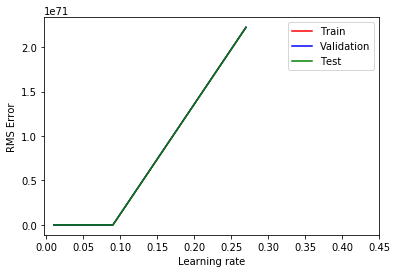

In [26]:
print(L_Erms_TR)
print(L_Erms_Val)
print(L_Erms_Test)

plt.plot(learningRate_candidates, L_Erms_TR, 'r',label='Train') 
plt.plot(learningRate_candidates, L_Erms_Val, 'b',label='Validation') 
plt.plot(learningRate_candidates, L_Erms_Test, 'g',label='Test') 
plt.xticks(np.arange(0,0.5,0.05)) 
#plt.yticks(np.arange(0,20,0.1))
plt.xlabel('Learning rate') 
plt.ylabel('RMS Error') 
plt.legend()
plt.show()

### Tuning Lamba

In [27]:
W_Now        = np.dot(220, W)
La_List      = [0.05,0.10,0.2,0.4,0.8,1.6,2]
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for La in La_List:
    #print('-------------------------Learning Rate: '+str(learningRate))
    for i in range(0,200):
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        #print('TR_TEST_OUT: '+ str(TR_TEST_OUT.shape))
        #print('TrainingTarget: '+ str(TrainingTarget.shape))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        #print('VAL_TEST_OUT: '+ str(VAL_TEST_OUT.shape))
        #print('ValDataAct: '+ str(ValDataAct.shape))
        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        #print('TEST_OUT: ' + str(TEST_OUT.shape))
        #print('TestDataAct: '+ str(TestDataAct.shape))

    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Erms_Val.append(float(Erms_Val.split(',')[1])) 
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

[27.53370233138407, 22.21490265477603, 14.653587565506998, 6.441752752209055, 1.2974856835071331, 0.5556917581406694, 0.5651117379749855]
[26.687747145690746, 21.523794223747817, 14.192374029255783, 6.237512786014696, 1.25966691873205, 0.5451084638766249, 0.5538826295169236]
[27.316437435461758, 22.03253658687748, 14.52591304449998, 6.379603067697908, 1.305014120997682, 0.6320727356002008, 0.6428596601511413]


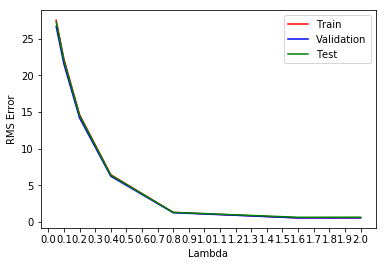

In [28]:
print(L_Erms_TR)
print(L_Erms_Val)
print(L_Erms_Test)

plt.plot(La_List, L_Erms_TR, 'r',label='Train') 
plt.plot(La_List, L_Erms_Val, 'b',label='Validation') 
plt.plot(La_List, L_Erms_Test, 'g',label='Test') 
plt.xticks(np.arange(0,2.1,0.1)) 
#plt.yticks(np.arange(0,20,0.1))
plt.xlabel('Lambda') 
plt.ylabel('RMS Error') 
plt.legend()
plt.show()

### Tuning Number of clusters

In [ ]:
W_Now        = np.dot(220, W)
learningRate = 0.01
La           = 2
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
number_of_clusters = [10,15,20,25]
for m in number_of_clusters:
    print(m)
    kmeans = KMeans(n_clusters=m, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_
    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    W_Now        = np.dot(220, W)
    for i in range(0,400):
    
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        
        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Erms_Val.append(float(Erms_Val.split(',')[1])) 
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

10
15
20
25


In [ ]:
print(L_Erms_TR)
print(L_Erms_Val)
print(L_Erms_Test)

plt.plot(number_of_clusters, L_Erms_TR, 'r',label='Train') 
plt.plot(number_of_clusters, L_Erms_Val, 'b',label='Validation') 
plt.plot(number_of_clusters, L_Erms_Test, 'g',label='Test') 
#plt.xticks(np.arange(0,26,5)) 
#plt.yticks(np.arange(0,20,0.1))
plt.xlabel('Number of Clusters') 
plt.ylabel('RMS Error') 
plt.legend()
plt.show()